In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
pd.set_option('max_rows', 20)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 3)
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
AQI_FILEPATH = os.path.join(os.curdir, 'data', 'aqi.csv')

df = pd.read_csv(filepath_or_buffer=AQI_FILEPATH, parse_dates=['datetime'], index_col='datetime', na_values='NR')
df_bak = df.copy()

# 保留降雨量為 NR 值的資料
df_withnr = pd.read_csv(filepath_or_buffer=AQI_FILEPATH, parse_dates=['datetime'], index_col='datetime')
df_withnr_bak = df_withnr.copy()

# 保留還未將 datetime 設為 index 的資料
df_noindex = pd.read_csv(filepath_or_buffer=AQI_FILEPATH)
df_noindex_bak = df_noindex.copy()

# 讀取未處理過的原始資料
AQI_ORIG_FILEPATH = os.path.join(os.curdir, 'data', 'aqi_original.csv')

df_orig = pd.read_csv(AQI_ORIG_FILEPATH)
df_orig_bak = df_orig.copy()

# 讀取還未使用 pivot_table() 處理過的資料
AQI_NOPIVOT_FILEPATH = os.path.join(os.curdir, 'data', 'aqi_nopivot.csv')

df_nopivot = pd.read_csv(AQI_NOPIVOT_FILEPATH, na_values=['NR'])
df_nopivot.replace(r'[-]?\D*[.]?\D*[#*x]+', np.nan, regex=True, inplace=True)
df_nopivot.loc[:, 'value'] = df_nopivot.loc[:, 'value'].astype(np.float64)
df_nopivot_bak = df_orig.copy()

In [4]:
df.head()

,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
datetime,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,20.0,2.0,0.20,0.04,1.7,7.5,9.2,25.0,67.0,18.0,NaN,88.0,1.5,2.0,33.0,37.0,1.4,0.1
2017-01-01 01:00:00,20.0,2.2,0.19,0.05,1.9,7.9,9.8,18.0,52.0,14.0,NaN,88.0,2.1,2.2,76.0,143.0,0.5,0.6
2017-01-01 02:00:00,19.0,2.2,0.24,0.08,2.0,9.3,11.0,13.0,59.0,17.0,NaN,89.0,2.0,2.3,140.0,142.0,0.5,0.6
2017-01-01 03:00:00,19.0,2.4,0.24,0.11,1.4,9.5,11.0,8.5,53.0,24.0,NaN,90.0,1.8,2.5,107.0,51.0,0.5,0.4
2017-01-01 04:00:00,18.0,3.4,0.23,0.12,6.8,11.0,17.0,1.8,37.0,25.0,NaN,90.0,1.7,3.6,96.0,106.0,1.0,0.5


### `pandas.get_dummies()`：One-hot Encoding——將名目尺度資料轉成 Dummy/Indicator Variables

在資料中不一定總是連續型數值，而有可能是名目尺度的資料，這些稱為資料的「狀態」。為了後續的分析需求，我們可以使用 **One-hot Encoding** 技術，將這些狀態各別編碼，將每個狀態放置於獨立的儲存單位。

至於何謂名目尺度的資料呢？舉例如下：

* 性別：`gender = ["male", "female"]`
* 國家：`country = ["Europe", "US", "Asia", "Taiwan"]`
* 瀏覽器名稱：`browser = ["Firefox", "Chrome", "Safari", "Internet Explorer"]`

所以以性別為例，若轉換前的資料為：

index | gender
--- | ---
0 |  male
1 |  female

則轉換後將為：

index | male | female
--- | --- | ---
0 |  1 | 0
1 |  0 | 1

* .get_dummies() : 將**類別資料**轉成 **Dummy Variable** 或 **Indicator Variables**
    * 常用 Parameters：
        1. data : array-like, Series, or DataFrame
        1. prefix : 預設為 `None`，產生新的 dummy variables column label 前面再加上一個名稱
        1. prefix\_sep : 如果有設定 `prefix`，則預設為 `_`，此為 `prefix` 值與原本的類別名稱之間的分隔符號
    * 參考文件：[pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)

In [5]:
# 建立一個測試的 DataFrame，命名為 people，其中包含以下 Column：
# 1. age: 年齡
# 2. gender: 性別
# 3. height: 身高
# 4. country: 國家
people = pd.DataFrame({
    "age":[23, 35, 29, 45, 30, 41], 
    "gender":['female', 'male', 'female', 'male', 'male', 'female'], 
    "height":[158.5, 175.6, 160.3, 170.5, 172.5, 168.0],
    "country":['Taiwan', 'Taiwan', 'Japan', 'China', 'Korea', np.nan]})
people

,age,gender,height,country
0,23,female,158.5,Taiwan
1,35,male,175.6,Taiwan
2,29,female,160.3,Japan
3,45,male,170.5,China
4,30,male,172.5,Korea
5,41,female,168.0,NaN


In [6]:
# 將國家 (column label: country) 資料改成 one-hot-encoding，再與原本的 people Dataframe 合併
# 產生新的 DataFrame，命名為 people_concat，並刪除國家 (column label: country) 欄位，
# Step 1. 使用 pandas.get_dummies() 產生 country 的 Dummy Variable
country_dummy = pd.get_dummies(people['country'], prefix='country', prefix_sep='_')
country_dummy

,country_China,country_Japan,country_Korea,country_Taiwan
0,0,0,0,1
1,0,0,0,1
2,0,1,0,0
3,1,0,0,0
4,0,0,1,0
5,0,0,0,0


In [7]:
# Step 2. 使用 pandas.concat() (在 chpater 6 的 concat()：根據座標軸來結合資料) 與原本的 test 合併
people_concat = pd.concat([people, country_dummy], axis=1)
people_concat

,age,gender,height,country,country_China,country_Japan,country_Korea,country_Taiwan
0,23,female,158.5,Taiwan,0,0,0,1
1,35,male,175.6,Taiwan,0,0,0,1
2,29,female,160.3,Japan,0,1,0,0
3,45,male,170.5,China,1,0,0,0
4,30,male,172.5,Korea,0,0,1,0
5,41,female,168.0,NaN,0,0,0,0


In [8]:
# Step 3. 使用 pandas.DataFrame.drop() (在 chpater 4 的 4.1 Modify DataFrame) 刪除 國家(column= country) 欄位
people_concat = people_concat.drop(columns='country')
people_concat

,age,gender,height,country_China,country_Japan,country_Korea,country_Taiwan
0,23,female,158.5,0,0,0,1
1,35,male,175.6,0,0,0,1
2,29,female,160.3,0,1,0,0
3,45,male,170.5,1,0,0,0
4,30,male,172.5,0,0,1,0
5,41,female,168.0,0,0,0,0


In [9]:
# 補充：設定 prefix 的差異
# 1. 未設定 prefix 與 prefix_sep 值
pd.get_dummies(people['country'])

,China,Japan,Korea,Taiwan
0,0,0,0,1
1,0,0,0,1
2,0,1,0,0
3,1,0,0,0
4,0,0,1,0
5,0,0,0,0


In [10]:
# 2. 設定 prefix = 'country', prefix_sep = '_'
pd.get_dummies(people['country'], prefix='country', prefix_sep='_')

,country_China,country_Japan,country_Korea,country_Taiwan
0,0,0,0,1
1,0,0,0,1
2,0,1,0,0
3,1,0,0,0
4,0,0,1,0
5,0,0,0,0


### `.rolling()`：移動選取子集合並聚合計算

常見的應用為計算**移動平均 (Moving Average)**，又稱「移動平均線」，簡稱均線，是技術分析中一種分析時間序列數據的方法。最常見的是利用股價、回報或交易量等變數計算出移動平均。

移動平均可撫平短期波動，反映出長期趨勢或周期。數學上，移動平均可視為一種卷積。

* 常用 Parameters ：
    1. `window`: 子集合的物件數量
    1. `min_periods`: 在每個子集合中，需要存在數值的數量。若數值數量少於此設定值，則該子集合的計算結果為 `NaN`
    1. `center`: 是否將每一個數值設為子集合的中間項，預設為 `False`
* 參考文件：
    * [pandas.DataFrame.rolling](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html)
    * [pandas.Series.rolling](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.rolling.html)
    * [移動平均 | Wikipedia](https://zh.wikipedia.org/zh-tw/移動平均)

In [11]:
# 範例：設定每一個子集合有 5 個數值，並對每個子集合計算平均值
df['AMB_TEMP'].rolling(5).mean()

datetime
2017-01-01 00:00:00     NaN
2017-01-01 01:00:00     NaN
2017-01-01 02:00:00     NaN
2017-01-01 03:00:00     NaN
2017-01-01 04:00:00    19.2
2017-01-01 05:00:00    18.6
2017-01-01 06:00:00    18.2
2017-01-01 07:00:00    18.0
2017-01-01 08:00:00    18.0
2017-01-01 09:00:00    18.4
                       ... 
2017-12-31 14:00:00    19.6
2017-12-31 15:00:00    19.4
2017-12-31 16:00:00    19.0
2017-12-31 17:00:00    18.6
2017-12-31 18:00:00    18.4
2017-12-31 19:00:00    18.0
2017-12-31 20:00:00    17.6
2017-12-31 21:00:00    17.4
2017-12-31 22:00:00    17.2
2017-12-31 23:00:00    17.0
Name: AMB_TEMP, Length: 8760, dtype: float64

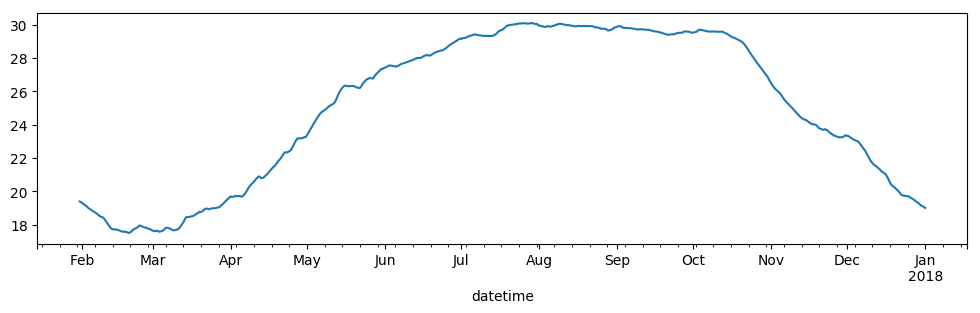

In [12]:
# 移動平均有「濾波」的效果，可以讓曲線較平滑，並過濾掉突波
# 以下示範以一個月的資料作為子集合並計算移動平均
df['AMB_TEMP'].fillna(method='bfill').rolling(720).mean().plot()

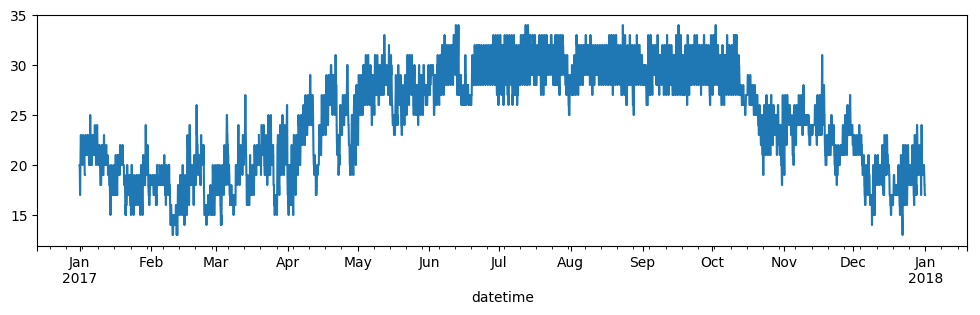

In [13]:
# 並與原始資料做比對
df['AMB_TEMP'].plot()

### `.shift()`：資料平移

* 常用 Parameters：
    1. `periods`: 輸入欲平移位置的個數，數值可為正整數或負整數
* 參考文件：
    * [pandas.DataFrame.shift](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html)
    * [pandas.Series.shift](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.shift.html)

In [14]:
features = pd.DataFrame({
    "A":[10, 10, 11, 9, 11.5], 
    "B":[5.5, 5.5, 5, 6.2, 5.8], 
    "C":[190, 200, 230, 260, 235]},
    index=pd.date_range('2018-01-01 00:00:00', freq='h', periods=5)
)
features

,A,B,C
2018-01-01 00:00:00,10.0,5.5,190
2018-01-01 01:00:00,10.0,5.5,200
2018-01-01 02:00:00,11.0,5.0,230
2018-01-01 03:00:00,9.0,6.2,260
2018-01-01 04:00:00,11.5,5.8,235


In [15]:
# 一個常見的範例，是將某個時間點的 Feature，與該 Feature 在 n 個單位以前的資料給結合
# 讓演算法可以參考該 Feature 在當下、以及一段時間以前的狀態

# 範例：製作出所有 Feature 在兩單位時間以前的狀態
features_shift = features.shift(periods=2)
features_shift.columns = [ x + '_t-2' for x in features.columns ]
features_shift

,A_t-2,B_t-2,C_t-2
2018-01-01 00:00:00,NaN,NaN,NaN
2018-01-01 01:00:00,NaN,NaN,NaN
2018-01-01 02:00:00,10.0,5.5,190.0
2018-01-01 03:00:00,10.0,5.5,200.0
2018-01-01 04:00:00,11.0,5.0,230.0


In [16]:
# 最後再將新的 Feature 與原始的 Feature 合併
pd.concat([features, features_shift], axis=1)

,A,B,C,A_t-2,B_t-2,C_t-2
2018-01-01 00:00:00,10.0,5.5,190,NaN,NaN,NaN
2018-01-01 01:00:00,10.0,5.5,200,NaN,NaN,NaN
2018-01-01 02:00:00,11.0,5.0,230,10.0,5.5,190.0
2018-01-01 03:00:00,9.0,6.2,260,10.0,5.5,200.0
2018-01-01 04:00:00,11.5,5.8,235,11.0,5.0,230.0


### `.diff()`：計算資料與某位置或某時間以前的差值

* 常用 Parameters：
    1. `periods`: 欲比較差值的位置，數值可為正整數或負整數
* 參考文件：
    * [pandas.DataFrame.diff](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html)
    * [pandas.Series.diff](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.shift.html)

In [17]:
values = pd.DataFrame({
    'a': [1, 2, 3, 4, 5, 6],
    'b': [1, 1, 2, 3, 5, 8],
    'c': [1, 4, 9, 16, 25, 36]})
values

,a,b,c
0,1,1,1
1,2,1,4
2,3,2,9
3,4,3,16
4,5,5,25
5,6,8,36


In [18]:
# 計算所有數值與本身相距兩個單位以前的差值
values.diff(2)

,a,b,c
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,2.0,1.0,8.0
3,2.0,2.0,12.0
4,2.0,3.0,16.0
5,2.0,5.0,20.0
